# TensorSensor

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/tensor-sensor/blob/master/testing/examples.ipynb)

TensorSensor clarifies exceptions by augmenting messages and visualizing Python code to indicate the shape of tensor variables (see figure to the right for a teaser). It works with Tensorflow, PyTorch, JAX, and Numpy, as well as higher-level libraries like Keras and fastai.  Besides trapping exceptions, TensorSensor can provide visualizations of code that executes without exception. You can also see the complete expression tree computation and the shapes of self-expression partial results.

See article [Clarifying exceptions and visualizing tensor operations in deep learning code](https://explained.ai/tensor-sensor/index.html) at [explained.ai](https://explained.ai).

## Clarifying the cause of tensor exceptions

In [1]:
import sys
%config InlineBackend.figure_format = 'retina'

In [2]:
! pip install -q tensorflow
! pip install -q jax jaxlib
! pip install -q numpy
! pip install -q torch
! pip install -q scikit-learn

In [3]:
! pip install -q tensor-sensor

In [4]:
import tsensor
tsensor.__version__

'1.0'

### TensorFlow

In [5]:
import tensorflow as tf

In [6]:
W = tf.constant([[1, 2], [3, 4]])
b = tf.reshape(tf.constant([[9, 10]]), (2, 1))
x = tf.reshape(tf.constant([[8, 5, 7]]), (3, 1))

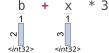

tensorflow says: Incompatible shapes: [2,1] vs. [3,1] [Op:AddV2]

tsensor adds: Cause: + on tensor operand b w/shape (2, 1) and operand x * 3 w/shape (3, 1)


In [7]:
try: # try-except prevents exception from stopping the flow of this notebook
    with tsensor.clarify():
        res = x * 3
        res = tf.matmul(W, b)
        b + x * 3
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("tensorflow says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

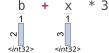

tensorflow says: Incompatible shapes: [2,1] vs. [3,1] [Op:AddV2]

tsensor adds: Cause: + on tensor operand b w/shape (2, 1) and operand x * 3 w/shape (3, 1)


In [8]:
def foo(): bar()
def bar():
    b + x * 3

try:
    with tsensor.clarify(): # works for any called functions too
        foo()
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("tensorflow says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

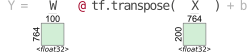

tensorflow says: Matrix size-incompatible: In[0]: [764,100], In[1]: [764,200] [Op:MatMul]

tsensor adds: Cause: @ on tensor operand W w/shape (764, 100) and operand tf.transpose(X) w/shape (764, 200)


In [9]:
import tensorflow as tf
n = 200         # number of instances
d = 764         # number of instance features
nhidden = 256
n_neurons = 100

W = tf.random.uniform((d,n_neurons))
b = tf.random.uniform((n_neurons,1))
X = tf.random.uniform((n,d))
try:
    with tsensor.clarify():
        Y = W @ tf.transpose(X) + b
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("tensorflow says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

### JAX

JAX actually gives very good shape messages but TensorSensor visualizes the specifics of expression with the problem.

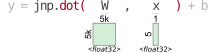

JAX says: Incompatible shapes for dot: got (5000, 5000) and (5, 1).

tsensor adds: Cause: jnp.dot(W, x) tensor arg W w/shape (5000, 5000), arg x w/shape (5, 1)


In [10]:
import jax.numpy as jnp
from jax import random

key = random.PRNGKey(0)

size = 5000
W = random.normal(key, shape=(size, size)).astype(jnp.float32)
x = random.normal(key, shape=(5, 1)).astype(jnp.float32)
x = random.normal(key, shape=(5, 1)).astype(jnp.float32)

try:
    with tsensor.clarify() as cl:
        y = jnp.dot(W, x) + b
except TypeError as e:
    msgs = str(e).split("\n")
    sys.stderr.write("JAX says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

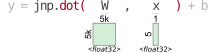

JAX says: Incompatible shapes for dot: got (5000, 5000) and (5, 1).

tsensor adds: Cause: jnp.dot(W, x) tensor arg W w/shape (5000, 5000), arg x w/shape (5, 1)


In [11]:
try:
    with tsensor.clarify() as cl:
        y = jnp.dot(W, x) + b
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("JAX says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

### NumPy

In [12]:
import numpy as np

W = np.array([[1, 2], [3, 4]])
b = np.array([9, 10]).reshape(2, 1)
x = np.array([4, 5]).reshape(2, 1)
h = np.array([1,2])

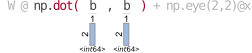

PyTorch says: shapes (2,1) and (2,1) not aligned: 1 (dim 1) != 2 (dim 0)

tsensor adds: Cause: np.dot(b,b) tensor arg b w/shape (2, 1), arg b w/shape (2, 1)


In [13]:
try: # try is used just to catch the exception and extract the messages
    with tsensor.clarify():
        W @ np.dot(b,b) + np.eye(2,2)@x
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

### PyTorch

In [14]:
import tsensor
import torch

W = torch.tensor([[1, 2], [3, 4]])
b = torch.tensor([9, 10]).reshape(2, 1)
x = torch.tensor([4, 5]).reshape(2, 1)
h = torch.tensor([1,2])

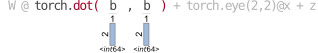

PyTorch says: 1D tensors expected, but got 2D and 2D tensors

tsensor adds: Cause: torch.dot(b,b) tensor arg b w/shape [2, 1], arg b w/shape [2, 1]


In [15]:
try: # try is used just to catch the exception and extract the messages
    with tsensor.clarify():
        W @ torch.dot(b,b) + torch.eye(2,2)@x + z
except BaseException as e:
    msgs = e.args[0].split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

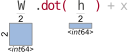

PyTorch says: 1D tensors expected, but got 2D and 1D tensors

tsensor adds: Cause: W.dot(h) tensor arg h w/shape [2]


In [16]:
try:
    with tsensor.clarify():
        W.dot(h) + x
except BaseException as e:
    msgs = e.args[0].split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

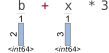

PyTorch says: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 0

tsensor adds: Cause: + on tensor operand b w/shape [2, 1] and operand x * 3 w/shape [3, 1]


In [17]:
x = torch.tensor([4, 5, 6]).reshape(3, 1)

try:
    with tsensor.clarify():
        b + x * 3
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

## Display elements

### Greater than 2 dimensions

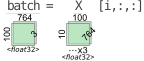

In [18]:
n_batches, batch_size, d = 10, 100, 764
i = 2
X = torch.rand(n_batches, batch_size, d, 3)
with tsensor.explain():
    batch = X[i,:,:]

### Color implies type, transparency implies precision

By default, green indicates floating-point, blue indicates integer, and orange indicates complex numbers. The more saturated the color (lower transparency), the higher the precision.

Unknown types are gray by default as are unknown precisions.

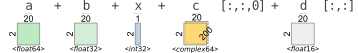

In [19]:
a = torch.rand(size=(2, 20), dtype=torch.float64)
b = torch.rand(size=(2, 20), dtype=torch.float32)
c = torch.rand(size=(2,20,200), dtype=torch.complex64)
d = torch.rand(size=(2,20), dtype=torch.float16)
x = torch.tensor([4, 5], dtype=torch.int32).reshape(2, 1)

with tsensor.explain():
    a + b + x + c[:,:,0] + d[:,:]

You can change the type colors, precisions available, and transparency ranges. Here are the defaults where `'other'` is the catchall for unknown types and precisions.

In [20]:
orangeish = '#FDD66C'
limeish = '#A8E1B0'
blueish = '#7FA4D3'
grey = '#EFEFF0'
dtype_colors = {'float':limeish, 'int':blueish, 'complex':orangeish, 'other':grey}
dtype_precisions = [32, 64, 128] # hard to see diff if we use [4, 8, 16, 32, 64, 128]
dtype_alpha_range = (0.5, 1.0)   # use (0.1, 1.0) if more precision values

For example, here is how to include 16-bit precision for floating-point (normally gray):

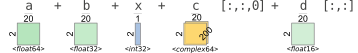

In [21]:
with tsensor.explain(dtype_precisions = [16, 32, 64, 128]):
    a + b + x + c[:,:,0] + d[:,:]

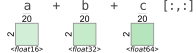

In [22]:
a = torch.rand(size=(2, 20), dtype=torch.float16)
b = torch.rand(size=(2, 20), dtype=torch.float32)
c = torch.rand(size=(2, 20), dtype=torch.float64)
with tsensor.explain(dtype_precisions = [16, 32, 64, 128]):
    a + b + c[:,:]

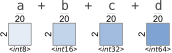

In [23]:
a = torch.zeros(size=(2, 20), dtype=torch.int8)
b = torch.zeros(size=(2, 20), dtype=torch.int16)
c = torch.zeros(size=(2, 20), dtype=torch.int32)
d = torch.zeros(size=(2, 20), dtype=torch.int64)
with tsensor.explain(dtype_precisions = [8, 16, 32, 64],
                     dtype_alpha_range=(0.2,1.0)):
    a + b + c + d

If, like the great [Oliver Zeigermann](https://zeigermann.eu/), you like insane colors, you can pass in a different color mapping:

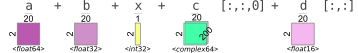

In [24]:
a = torch.rand(size=(2, 20), dtype=torch.float64)
b = torch.rand(size=(2, 20), dtype=torch.float32)
c = torch.rand(size=(2,20,200), dtype=torch.complex64)
d = torch.rand(size=(2,20), dtype=torch.float16)
x = torch.tensor([4, 5], dtype=torch.int32).reshape(2, 1)

wow = {'float':'#A22396', 'int':'#FBFF0B', 'complex':'#37FFA5',
       'other':'#F5B7EF'}
with tsensor.explain(dtype_colors=wow):
    a + b + x + c[:,:,0] + d[:,:]

## Explaining matrix algebra statements visually

In [25]:
W = torch.rand(size=(2000,2000), dtype=torch.float32)
b = torch.rand(size=(2000,1))
h = torch.rand(size=(1_000_000,)).type(torch.int16)
x = torch.rand(size=(2000,1)).type(torch.int)

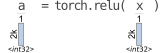

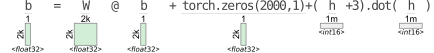

In [26]:
import tsensor
with tsensor.explain() as explained:
    a = torch.relu(x)
    b = W @ b + torch.zeros(2000,1)+(h+3).dot(h)

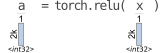

In [27]:
explained.views[0]

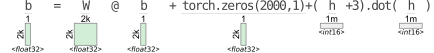

In [28]:
explained.views[1]

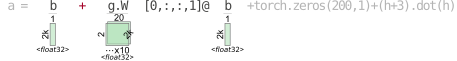

torch says: The size of tensor a (2000) must match the size of tensor b (20) at non-singleton dimension 0

torch adds: Cause: + on tensor operand b w/shape [2000, 1] and operand g.W[0,:,:,1]@b w/shape [20, 1]


In [29]:
class GRU: # fake random junk
    def __init__(self):
        self.W = torch.rand(size=(2,20,2000,10))
        self.b = torch.rand(size=(20,1))

# W = torch.tensor([[1, 2], [3, 4]])
b = torch.rand(size=(2000,1))
h = torch.rand(size=(1_000_000,2))

g = GRU()
try:
    with tsensor.explain():
        a = 3
        a = b + g.W[0,:,:,1]@b+torch.zeros(200,1)+(h+3).dot(h)
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("torch says: "+msgs[0]+'\n\n')
    sys.stderr.write("torch adds: "+msgs[1]+'\n')

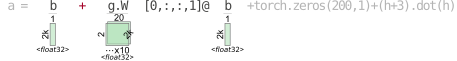

torch says: The size of tensor a (2000) must match the size of tensor b (20) at non-singleton dimension 0

torch adds: Cause: + on tensor operand b w/shape [2000, 1] and operand g.W[0,:,:,1]@b w/shape [20, 1]


In [30]:
try:
    with tsensor.clarify():
        a = b + g.W[0,:,:,1]@b+torch.zeros(200,1)+(h+3).dot(h)
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("torch says: "+msgs[0]+'\n\n')
    sys.stderr.write("torch adds: "+msgs[1]+'\n')

### Saving explanations to files

In [31]:
W = torch.rand(size=(2000,2000))
b = torch.rand(size=(2000,1))
h = torch.rand(size=(1_000_000,))
x = torch.rand(size=(2000,1))

with tsensor.explain(savefig="/tmp/foo.svg"): # save foo-1.svg and foo-2.svg in /tmp
    a = torch.relu(x)
    b = W @ b + x * 3 + h.dot(h)

In [32]:
!ls -l /tmp/foo-?.svg

-rw-r----- 1 parrt primarygroup 17973 Apr  7 13:48 /tmp/foo-1.svg
-rw-r----- 1 parrt primarygroup 28139 Apr  7 13:48 /tmp/foo-2.svg


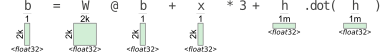

In [33]:
from IPython.display import SVG
display(SVG("/tmp/foo-2.svg"))

## Lower-level API to show abstract syntax trees (AST) and evaluate them

### Get ast and computation result

In [34]:
root, result = tsensor.eval("W @ b + x * 3 + h.dot(h)")  # use current context to evaluate.
result

tensor([[3.3651e+08],
        [3.3204e+08],
        [3.2950e+08],
        ...,
        [3.3568e+08],
        [3.3557e+08],
        [3.3285e+08]])

### Show the ast

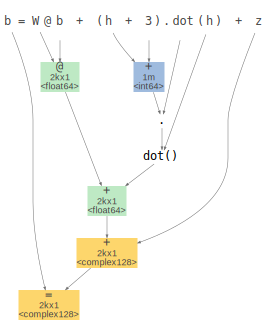

In [35]:
W = torch.rand(size=(2000,2000), dtype=torch.float64)
b = torch.rand(size=(2000,1), dtype=torch.float64)
h = torch.zeros(size=(1_000_000,), dtype=int)
x = torch.rand(size=(2000,1))
z = torch.rand(size=(2000,1), dtype=torch.complex64)

g = tsensor.astviz("b = W@b + (h+3).dot(h) + z", sys._getframe()) # don't eval, just show AST
g

In [36]:
g.savefig("/tmp/ast.svg")

In [37]:
g.savefig("/tmp/ast.pdf")

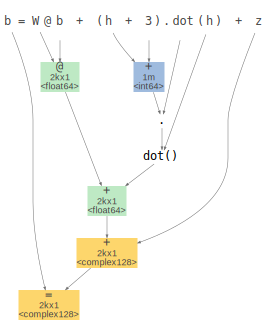

In [38]:
display(SVG("/tmp/ast.svg"))

### Show specific code w/o need of a `with` statement:

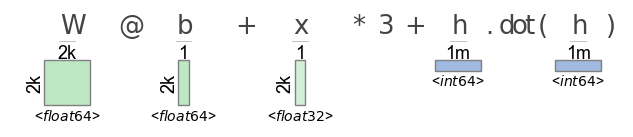

In [39]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(1,1)
tsensor.pyviz("W @ b + x * 3 + h.dot(h)", ax=ax)
plt.show()

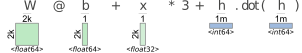

In [40]:
view = tsensor.pyviz("W @ b + x * 3 + h.dot(h)")
view.show()